In [4]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATTERY_PARTS = [
    '281700','282200','392020','392051','392119','392310', 
    '420212','721240','722230','722699','730120','730690', 
    '732619','732620','740822','740919','740921','741011', 
    '741220','741533','750522','750610','750620','760612', 
    '760719','790700','810590','831110','831120','831190', 
    '850110','850120','850590','850640','850660','850730', 
    '850780','853223','853340','854190','854370','854519', 
    '854720','860900','391910','391990','392069','731822', 
    '854449','391732','280430','290123','292390','281122', 
    '390230','853223','854720','760410','740990','853223', 
    '854720','760410','740990','282300','284210','740811', 
    '853630','382499','761699','830249','854411','848049', 
    '850790','732690','280440','854290','731816','830230', 
    '392099','401699','730711','741999','850680','853222', 
    '390210','382490','854442','282110','853890','853610', 
    '850450','732599','392690','730890','731100','853641'
]

BATTERY_PARTS_DICT = {
    'Aluminum foil': ['760410','760612','760719','761699'],
    'Anode Paste': ['281122','282110','282300','281700'],
    'Copper foil': ['740811','740822','740919','740921','740990','741011','741220','741533'],
    'Cathode': ['810590','280430'],
    'Cathode Paste': ['282200'],
    'Electrolyte': ['382499','292390','284210','290123','280440','382490'],
    'Battery Separator': ['390210','390230','401699'],
    'Anode': ['790700','854519'],
    'Cylinder Cell': ['731100'],
    'Spacer': ['392310','392020'],
    'Wire': ['831120','831190'],
    'Cases': ['721240','722230','722699','730120','730690','730890','731816','731822','732599','732619','732620','391732','391910','391990','392051','392069','392099','392690','848049','860900','854720','420212'],
    'Nickel Tab': ['750522','750610','750620'],
    'Battery Cell': ['850640','850660','850680'],
    'BMS':['850450','850730','850780','850790','853222','853223','853321','853340','853630','853641','853890','854190','854239','854290','854411','854442','854449'],
    'BATTERY': ['850760']
}

from collections import defaultdict
INV_BATTERY_PARTS_DICT = defaultdict()
for key, value in BATTERY_PARTS_DICT.items():
    for v in value:
        INV_BATTERY_PARTS_DICT[v] = key

BATTERY = '850760'
NUM_SUPPLIERS = 100

In [8]:
import http.cookiejar as cookielib
import pandas as pd
import requests
import warnings
import logging
import sqlite3
import boto3
import glob
import json
import time
import math
import tqdm
import sys
import os
import datetime

sys.path.append("/opt/libs")
from apiclass import APIClass,RedshiftClass
from apikeyclass import APIkeyClass
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 


# Get Top Suppliers of Battery

In [9]:
query = f"select * from index_hs6;"
index = rs.query_df(query)

In [10]:
# Check for missing values
index[index['hs6'] == BATTERY].isna().sum()

supplier_t      0
supplier_id     0
buyer_t         0
buyer_id        0
hs6             0
st              0
et              0
bill_count      0
quantity_sum    0
amount_sum      0
weight_sum      0
dtype: int64

In [11]:
def generate_battery_suppliers(index, method_name=None, count=NUM_SUPPLIERS, df_print=False):   
    if method_name is not None:
        top_suppliers_df = index[index['hs6'] == BATTERY].groupby('supplier_t').agg(
                               indicator_value=(method_name, 'sum')
                           ).sort_values(
                               ["indicator_value"], ascending = False
                           )
    else:
        raise ValueError('Must specify a method for defining largest supplier.')
    if df_print: 
        pd.set_option('display.max_rows', count+1)
        print(top_suppliers_df.head(count))
        pd.reset_option("all")
    top_suppliers = top_suppliers_df.head(count).index
    assert len(top_suppliers) == count
    return top_suppliers

In [12]:
battery_suppliers = generate_battery_suppliers(index, method_name="bill_count", df_print=True)
battery_suppliers

                                                    indicator_value
supplier_t                                                         
sevt                                                          21289
dell global b.v                                                6061
sdiv                                                           5971
amperex technology limited                                     4428
wistron corporation                                            3845
byd lithium battery co.,ltd                                    3800
hp international sarl                                          2298
samsung sdi co., ltd                                           1706
tianjin samsung sdi co., ltd                                   1532
samsung sdi energy malaysia sdn. bhd                           1523
elentec vietnam energy co.,ltd                                 1509
cong ty tnhh samsung sdi viet nam                              1193
itm semiconductor vietnam co., ltd              

Index(['sevt', 'dell global b.v', 'sdiv', 'amperex technology limited',
       'wistron corporation', 'byd lithium battery co.,ltd',
       'hp international sarl', 'samsung sdi co., ltd',
       'tianjin samsung sdi co., ltd', 'samsung sdi energy malaysia sdn. bhd',
       'elentec vietnam energy co.,ltd', 'cong ty tnhh samsung sdi viet nam',
       'itm semiconductor vietnam co., ltd',
       'yiwu yihuang import export compan', 'tianjin samsung sdi co ltd',
       'sehc', 'samsung electronics vietnam thai nguyen co.,ltd',
       'cong ty tnhh dien tu samsung hcmc ce complex', 'samsung sdi co.,ltd',
       'cong ty tnhh samsung electronics viet nam',
       'tianjin samsung sdi co.,ltd', 'samsung electronics co., ltd',
       'verdant crest technology dmcc', 'samsung sdi co. ltd',
       'tianjin samsung sdi co ., ltd', 'luxshare precision limited',
       'railhead corporation', 'navitasys technology limited',
       'motorola mobility llc', 'apple south asia pte. ltd',
       'wing

# BFS on a supplier

In [13]:
def construct_battery_subgraph(suppliers, tiers, early_stop=True, as_nx=False, nx_kwargs=None):
    '''
    Search starts from tier 1 and exhausts after reaching tier 'tiers'. Note that 'suppliers' are tier 1.
    early_stop: Stop when BFS is exhausted despite not reaching 'tiers'. 
                Store the last explored valid tier in 'early_stop_tier', 
                otherwise 'early_stop_tier' is 'tier'
    '''
    assert tiers >= 1
    early_stop_tiers = tiers
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df.loc[:,['supplier_t','buyer_t','hs6', 'bill_count']]
    bom_df["tier"]  = None
    
    subgraph_df = pd.DataFrame(columns=bom_df.columns)
    
    # Find tier 1 supplier_t -> buyer_t edge with hs6 == BATTERY (i.e. supplier_t is in suppliers)
    df = bom_df[(bom_df['supplier_t'].isin(suppliers)) & (bom_df['hs6']==BATTERY)].copy() # 
    df['tier'] = df['tier'].fillna(1)
    subgraph_df = pd.concat([subgraph_df, df])    
    
    new_suppliers = set(suppliers)
    all_suppliers = set(suppliers)
    
    # Find all suppliers that has buyer to be tier 1 supplier_t
    for t in range(2, tiers + 1):    
        df = bom_df[(bom_df['buyer_t'].isin(new_suppliers)) & (bom_df['hs6'].isin(BATTERY_PARTS))].copy()
        df['tier'] = df['tier'].fillna(t)
        subgraph_df = pd.concat([subgraph_df, df])
        
        new_suppliers = set(df[df.supplier_t.str.len() > 0].supplier_t.unique())
        new_suppliers = new_suppliers - all_suppliers
        if early_stop and len(new_suppliers) == 0:
            early_stop_tiers = t # denotes last tier of supplier
            break
        all_suppliers = all_suppliers.union(new_suppliers)

    return subgraph_df.sort_values(['tier', 'buyer_t'], ascending = True), early_stop_tiers

display(construct_battery_subgraph(['dell global b.v'], 100)[0])

,supplier_t,buyer_t,hs6,bill_count,tier
93593,dell global b.v,bordertrade management inc,850760,13,1
168506,dell global b.v,bordertrade management inc. bmi co,850760,1,1
42745,dell global b.v,bridges worldwide pvt ltd,850760,1,1
42148,dell global b.v,dell international services india private limited,850760,5990,1
92770,dell global b.v,fao dell global b.v,850760,23,1
44471,dell global b.v,gie solomon,850760,3,1
92771,dell global b.v,petroleum general distribution services joint ...,850760,1,1
44472,dell global b.v,vietnam post,850760,1,1
118467,dell global b.v,vstecs phils. inc,850760,16,1
92772,dell global b.v,ych-protrade company limited,850760,12,1


In [14]:
# print out the df that has cycles
MAX_TIER = 100
for bat in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    if max(battery_subgraph[0]['tier']) == battery_subgraph[1]:
        display(battery_subgraph[0])
        print(battery_subgraph[1])

,supplier_t,buyer_t,hs6,bill_count,tier
53981,cong ty tnhh dien tu samsung hcmc ce complex,"samsung electronics hcmc ce complex co., ltd",850760,22,1
53998,cong ty tnhh dien tu samsung hcmc ce complex,sehc,850760,609,1
3014,jc vina company limited,cong ty tnhh dien tu samsung hcmc ce complex,391910,1,2
4163,"lxg co.,ltd",cong ty tnhh dien tu samsung hcmc ce complex,761699,3,2
10167,dev,cong ty tnhh dien tu samsung hcmc ce complex,391990,23,2
...,...,...,...,...,...
17349,"donggok precision co., ltd","s-1 corporation vietnam co., ltd",732690,2,3
24674,"donggok precision co., ltd","s-1 corporation vietnam co., ltd",854370,2,3
81576,"donggok precision co., ltd","s-1 corporation vietnam co., ltd",392690,1,3
28510,jc vina company limited,cong ty tnhh dien tu samsung hcmc ce complex dncx,391990,2,4


4


# Analysis

In [15]:
MAX_TIER = 100

## Q1: as tier increases, when does the graph die? (trend: tier vs num_new_row)

In [16]:
# Q1.1: Size of graph (num_node) for each battery supplier (largest to smallest, top NUM_SUPPLIERS)
dict_ = {'supplier_t' : [], 'num_txn' : []}
for supplier in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([supplier], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    
    dict_['supplier_t'].append(supplier)
    dict_['num_txn'].append(len(battery_subgraph[0]))
df = pd.DataFrame(dict_)
display(df)

,supplier_t,num_txn
0,sevt,9065
1,dell global b.v,19
2,sdiv,9313
3,amperex technology limited,6
4,wistron corporation,33
...,...,...
95,neway trading development limited,3
96,asus global pte. ltd,11
97,samsung electronics co. ltd,9012
98,truper herramientas sa de cv,556


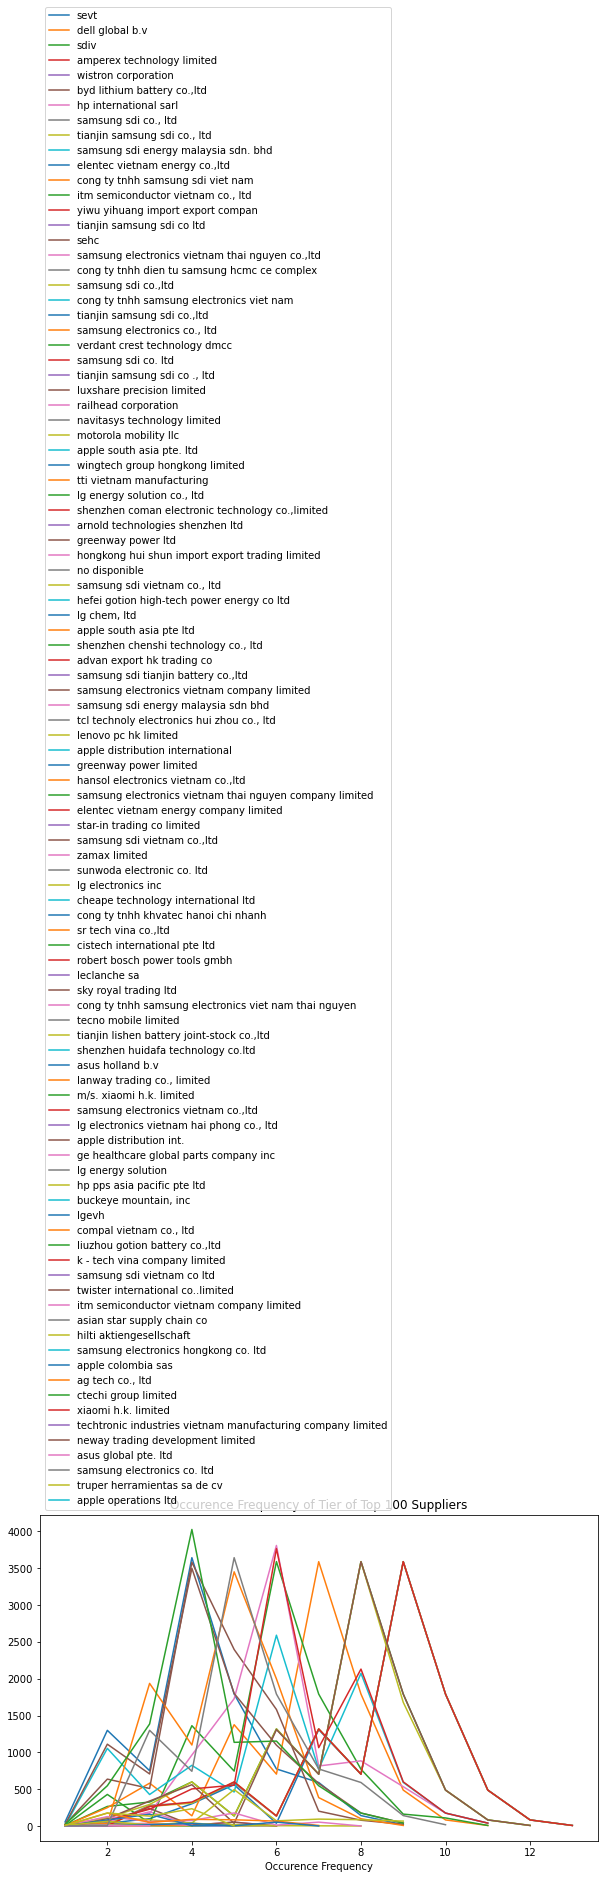

In [17]:
# Q1.2: Where's a supplier at in the supply chain? 
# A1.2: Plot for Top NUM_SUPPLIERS: x-axis is 'tier', y-axis is count of occurence
plt.figure(figsize=(10,6))
for bat in battery_suppliers[:NUM_SUPPLIERS]:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    tier_df = battery_subgraph[0].groupby(['tier'])['tier'].count()
    
    x = list(tier_df.index)
    y = list(tier_df.values)
    
    # check tier
    plt.plot(x, y, label = bat)

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)
plt.xlabel("Tier")
plt.xlabel("Occurence Frequency")
plt.title("Occurence Frequency of Tier of Top " + str(NUM_SUPPLIERS) + " Suppliers")
plt.show()

## Q2: 'hs6' vs tier as tree depth mean across top suppliers. If BOM correct, we expect the empirical plot to be consistent

In [18]:
construct_battery_subgraph(['dell global b.v'], MAX_TIER)[0]['tier'].values[0] + 1

2

In [19]:
# Construct dicts to record hs_6 code and tier list
def construct_hs6_to_tier(battery_suppliers):
    hs6_dict = defaultdict(list) # set(hs_6(s)) -> tier mean, std, sum

    for bat in battery_suppliers:
        battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
        assert(battery_subgraph[1] < MAX_TIER)
        for _, row in battery_subgraph[0].iterrows():
            hs6_dict[row['hs6']].append(row['tier'])
    return hs6_dict

hs6_dict = construct_hs6_to_tier(battery_suppliers)

In [20]:
# Calculate tier info (mean, std, sum) per grouping, sum here means cnt of tx
# grouping is like BATTERY_PARTS_DICT: group_name -> list of hs6_code
def calculate_tier_info(hs6_dict, grouping=None):
    import statistics
    hs6_group_dict = defaultdict(list)
    if grouping == None:
        grouping = {hs6: [hs6] for hs6 in hs6_dict}

    for key in grouping:
        values = []
        for hs6 in grouping[key]:        
            values += hs6_dict[hs6]
        mean = statistics.mean(values) if len(values) > 0 else -1
        std = statistics.stdev(values) if len(values) > 1 else -1 # If stdev not applicable, use -1
        summ = len(values)
        hs6_group_dict[key] = [mean, std, summ]
    df = pd.DataFrame.from_dict(hs6_group_dict, orient='index', columns=['tier_mean','tier_std','tier_sum'])
    df = df.sort_values(['tier_mean'], ascending = False)
    return df

In [21]:
# Sanity check: info of BATTERY = 850760 row
# Sanity check: the ordering of index (hs6 code) should resemble BOM tree, not necessarily numerically equally-spaced

In [22]:
def plot_tier_info(df, category_label=False):
    # Add category label to hs code df index
    if category_label:
        category_index = []
        for hs6 in df.index:
            if hs6 in INV_BATTERY_PARTS_DICT:
                category_index.append(hs6 + ":" + INV_BATTERY_PARTS_DICT[hs6])
            else:
                category_index.append(hs6 + ":" + "Other")
        df["temp"] = category_index
        df = df.set_index("temp")
    
    
    # Plot of distribution of mean, sum, std
    plt.subplots(figsize=(15, 5))

    num_bins = round((max(df['tier_mean']) - min(df['tier_mean'])) * 4)

    plt.subplot(1, 3, 1)
    plt.hist(df['tier_mean'], bins=num_bins)
    plt.title('Distribution of tier mean')
    plt.xlabel('Tier Mean Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(df['tier_std'], bins=num_bins)
    plt.title('Distribution of tier stdev')
    plt.xlabel('Tier Stdev Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(df['tier_sum'], bins=num_bins)
    plt.title('Distribution of tier sum')
    plt.xlabel('Tier Sum Value')
    plt.ylabel('Count')

    # space between the plots
    plt.tight_layout()

    # show plot
    plt.show()
    
    # Per hs code: plot of mean, variance, overlapped with sum histogram
    x = np.array(df.index)
    y = np.array(df['tier_mean'].values)
    e = np.array(df['tier_std'].values)
    s = np.array(df['tier_sum'].values)

    SUM_SCALE = max(s) / 2

    plt.figure(figsize=(20, 10))
    plt.errorbar(x, y, e, linestyle='-', marker='*', ecolor='green')
    plt.bar(x, s / SUM_SCALE, alpha=0.5, label='sum') # Scaled to show trend (maximum is 2) not actual values
    plt.xticks(rotation = 90)
    plt.title("Per grouping, plot of mean with stdev error bar, overlapped with scaled sum historgram of tier values")
    plt.show()
    

,tier_mean,tier_std,tier_sum
740822,7.785714,2.341051,56
750522,6.900000,2.359750,20
420212,6.875706,2.653541,177
850660,6.868132,1.922296,182
392051,6.805556,2.305162,72
830230,6.733333,1.965018,150
722230,6.713178,2.319058,129
392020,6.712695,1.983172,898
854290,6.646008,2.134713,952
850640,6.589041,2.001162,219


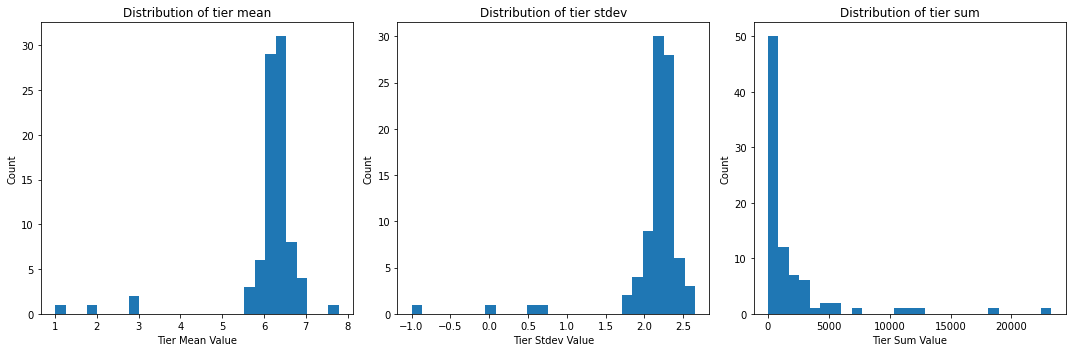

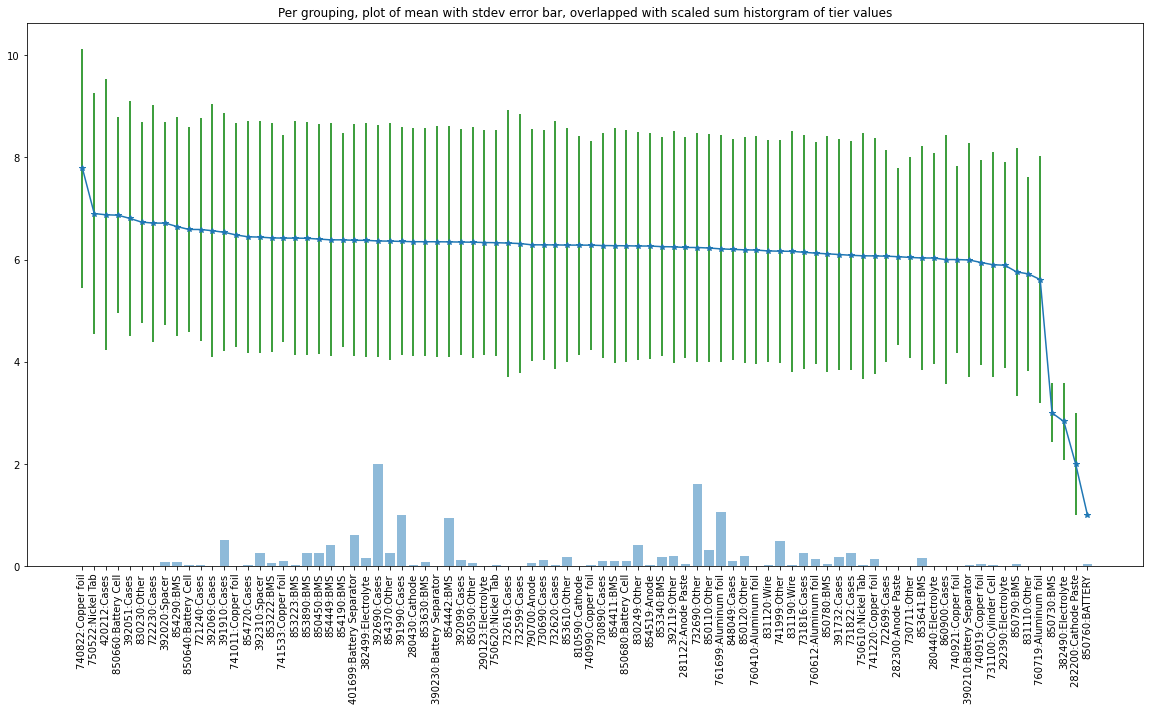

In [23]:
# Q2.1: Per hs_code, how does the graph look like?
df = calculate_tier_info(hs6_dict)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df, True)

,tier_mean,tier_std,tier_sum
Spacer,6.501258,2.205723,3974
Battery Cell,6.382669,2.204639,1581
Battery Separator,6.363955,2.273408,7413
Cases,6.337370,2.268438,56315
BMS,6.332450,2.255227,31307
Electrolyte,6.330254,2.271017,2165
Cathode,6.328228,2.197869,457
Anode,6.282443,2.254023,917
Anode Paste,6.228889,2.145812,450
Copper foil,6.221460,2.174029,3644


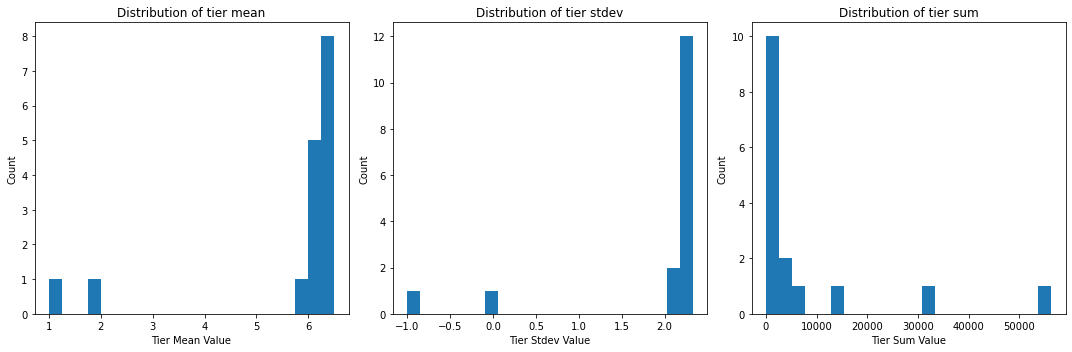

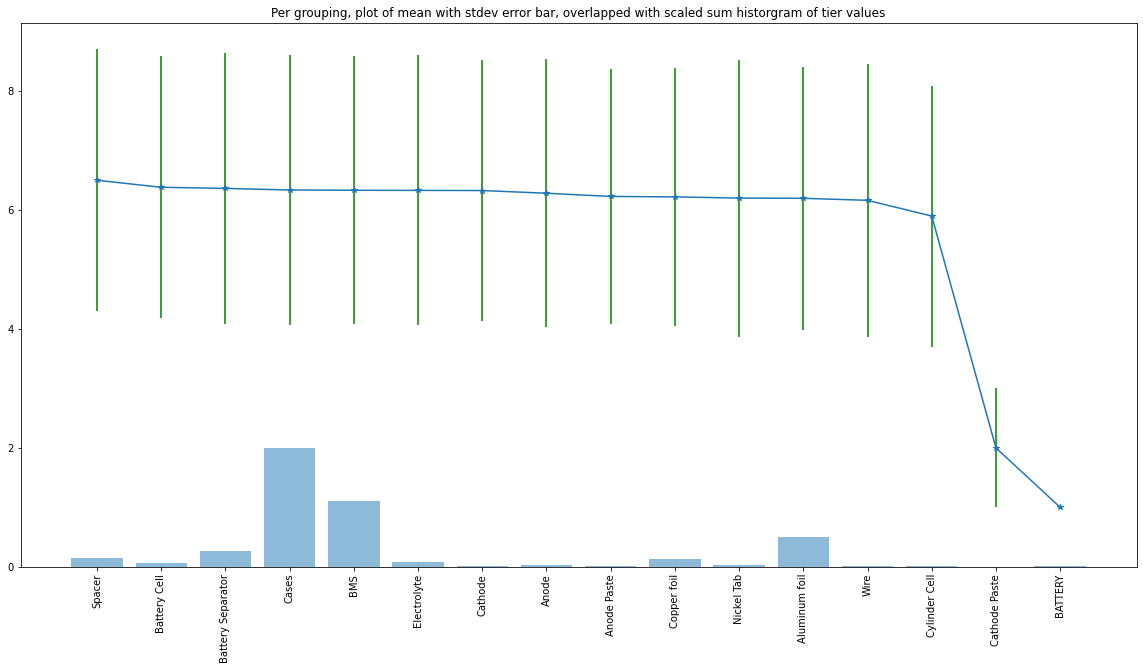

In [24]:
# Q2.2: Per bom grouping, how does the graph look like?
df = calculate_tier_info(hs6_dict, BATTERY_PARTS_DICT)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df)

## Q3: Evaluate missingness
How many hs_codes we expect to see actually show up in the subgraph of the battery makers?

In [25]:
hs6_dict.keys()

dict_keys(['850760', '732690', '741999', '850110', '854442', '850780', '401699', '853340', '761699', '854519', '853641', '392690', '850120', '731816', '391990', '392119', '731822', '740919', '853630', '741220', '741533', '732620', '853890', '392099', '830249', '850680', '854449', '760612', '831190', '391910', '850450', '392310', '730690', '848049', '280430', '280440', '382499', '854370', '853222', '831110', '853610', '290123', '292390', '854411', '391732', '760410', '790700', '281122', '390210', '732599', '750620', '730890', '850590', '854720', '740990', '850640', '392020', '392069', '722699', '810590', '392051', '831120', '853223', '850660', '420212', '731100', '722230', '282300', '730711', '854290', '850790', '721240', '741011', '750610', '854190', '830230', '860900', '390230', '760719', '732619', '740822', '750522', '850730', '382490', '282200', '740921', '282110', '281700', '740811', '284210', '730120', '853321', '854239'])

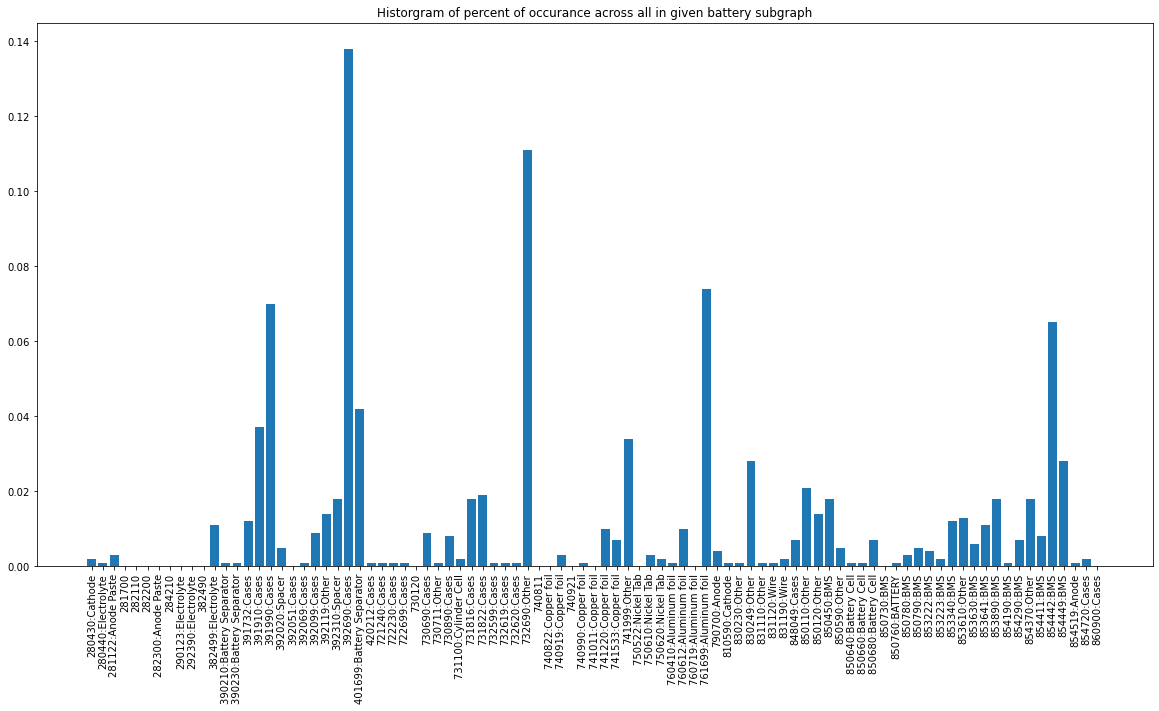

(                      count  percent
 temp                                
 392690:Cases           1287    0.138
 732690:Other           1035    0.111
 761699:Aluminum foil    691    0.074
 391990:Cases            655    0.070
 854442:BMS              605    0.065
 ...                     ...      ...
 760719:Aluminum foil      2    0.000
 292390:Electrolyte        2    0.000
 850730:BMS                1    0.000
 282300:Anode Paste        1    0.000
 750522:Nickel Tab         1    0.000
 
 [83 rows x 2 columns],
 {'281700',
  '282110',
  '282200',
  '284210',
  '382490',
  '730120',
  '740811',
  '740921'})

In [26]:
# Q3.1: given companies [list], construct subgraph and count distribution of hs_codes 
def evaluate_missingness(companies, plot=False, category_label=False):
    battery_subgraph = construct_battery_subgraph(companies, MAX_TIER)[0]
    dict_ = defaultdict(int)
    df = battery_subgraph.groupby(['hs6']).count() # col 'supplier_t' is a placeholder 
    df = df.rename(columns={"supplier_t": "count"})
    df['percent'] = round(df['count'] / df['count'].sum(), 3)
    df = df.sort_values(["count"], ascending = False)
        
    assert (set(df.index) - set(BATTERY_PARTS + [BATTERY])) == set()
    missing_parts = set(BATTERY_PARTS + [BATTERY]) - set(df.index)
    if plot:
        # Add category label to hs code df index
        if category_label:
            category_index = []
            for hs6 in df.index:
                if hs6 in INV_BATTERY_PARTS_DICT:
                    category_index.append(hs6 + ":" + INV_BATTERY_PARTS_DICT[hs6])
                else:
                    category_index.append(hs6 + ":" + "Other")
            df["temp"] = category_index
            df = df.set_index("temp")
        
        plt.figure(figsize=(20, 10))
        x = list(df.index) + list(missing_parts)
        y = list(df['percent'].values) + [0] * len(missing_parts)
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness(battery_suppliers[2:3], True, True)

Parts in grouping holds 0.75 porportion of all hs6 codes.


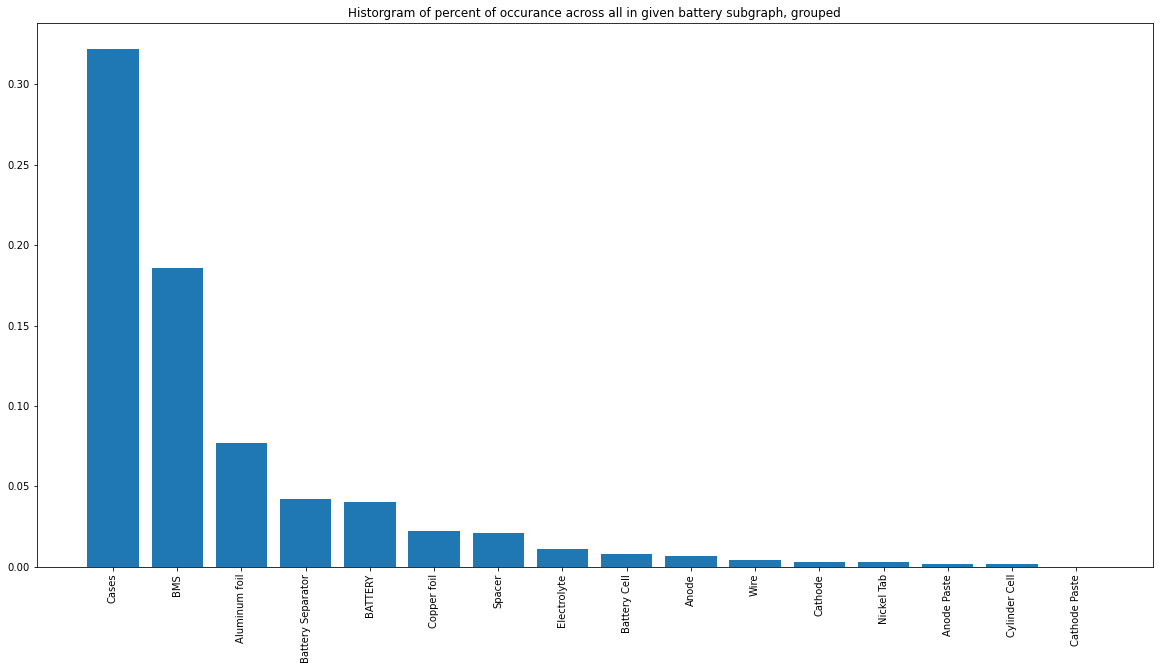

(                   count  percent
 hs6                              
 Aluminum foil        951    0.077
 Anode                 83    0.007
 Anode Paste           25    0.002
 BATTERY              495    0.040
 BMS                 2281    0.186
 Battery Cell         101    0.008
 Battery Separator    520    0.042
 Cases               3986    0.322
 Cathode               28    0.003
 Cathode Paste          1    0.000
 Copper foil          272    0.022
 Cylinder Cell         21    0.002
 Electrolyte          148    0.011
 Nickel Tab            48    0.003
 Spacer               261    0.021
 Wire                  43    0.004,
 {'281700', '282110', '284210', '730120', '740811'})

In [27]:
# Q3.2: given companies [list], construct subgraph and count distribution by grouping of hs_codes
def evaluate_missingness_group(companies, grouping, plot=False):
    df, missing_parts = evaluate_missingness(companies)
    df = df.groupby(by=grouping, axis=0).sum()
    print("Parts in grouping holds", df['percent'].sum(), "porportion of all hs6 codes.")
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(df.index)
        y = list(df['percent'].values)
        
        # Sort by value from large to small
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph, grouped")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness_group(battery_suppliers[0:NUM_SUPPLIERS], INV_BATTERY_PARTS_DICT, True)

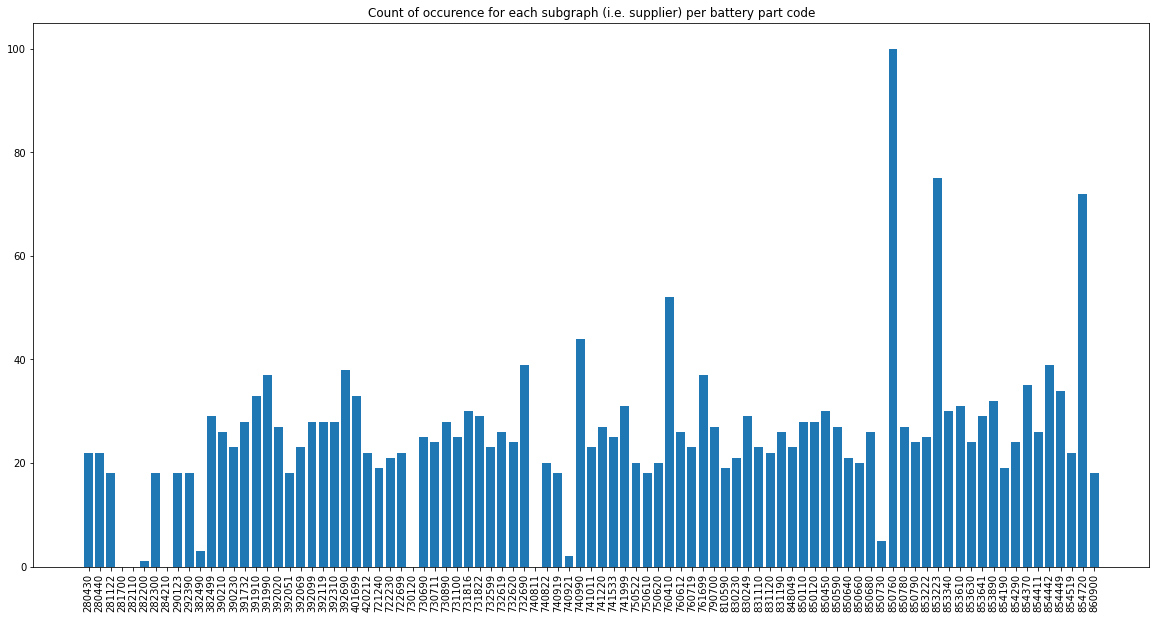

,cnt
281700,0
282200,1
392020,27
392051,18
392119,28
...,...
392690,38
730890,28
731100,25
853641,29


In [28]:
# Q3.3: count of subgraphs that has each battery part code?
def supplier_cnt_per_battery_part(suppliers, plot=False):
    cnt_dict = dict.fromkeys(BATTERY_PARTS + [BATTERY], 0)
    for supplier in suppliers:
        subgraph_df = construct_battery_subgraph([supplier], MAX_TIER)[0]
        subgraph_hs6_set = set(subgraph_df['hs6'])
        for hs6 in BATTERY_PARTS + [BATTERY]:
            cnt_dict[hs6] += (hs6 in subgraph_hs6_set)
            
    cnt_df = pd.DataFrame.from_dict(cnt_dict, orient='index', columns=["cnt"])
    
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(cnt_dict.keys())
        y = list(cnt_dict.values())
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Count of occurence for each subgraph (i.e. supplier) per battery part code")
        plt.show()

    return cnt_df
supplier_cnt_per_battery_part(battery_suppliers[0:NUM_SUPPLIERS], True) 

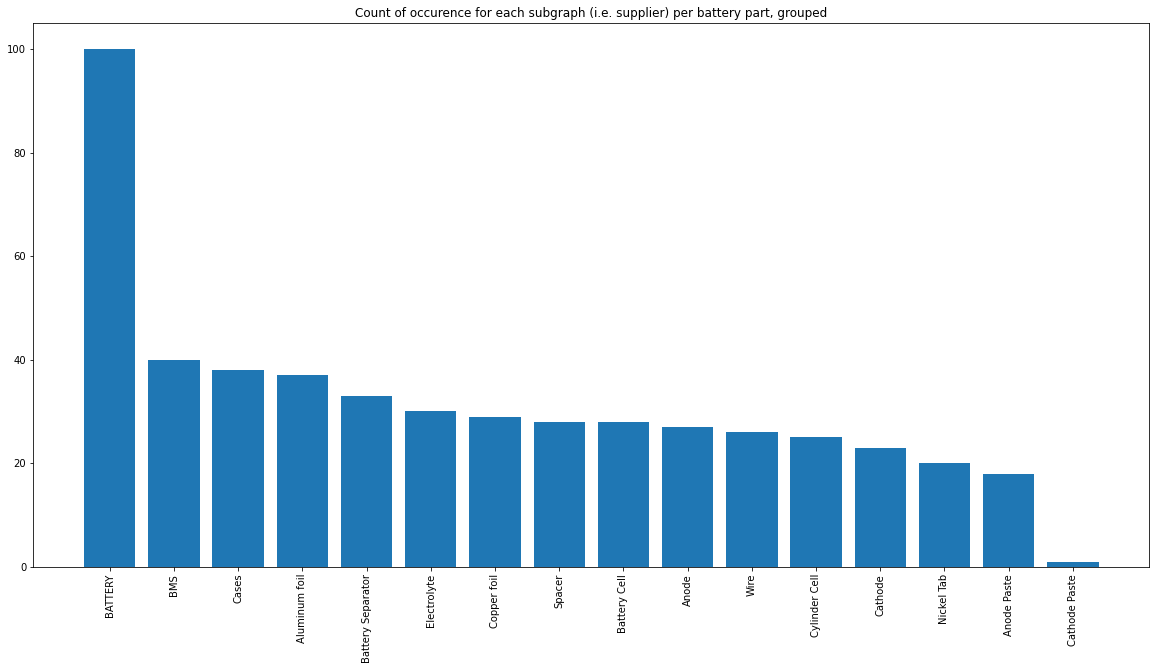

,cnt
Aluminum foil,37
Anode Paste,18
Copper foil,29
Cathode,23
Cathode Paste,1
Electrolyte,30
Battery Separator,33
Anode,27
Cylinder Cell,25
Spacer,28


In [29]:
# Q3.4: count of subgraphs that has each battery part?
def supplier_cnt_per_battery_part_group(suppliers, grouping, plot=False):
    cnt_dict = dict.fromkeys(BATTERY_PARTS_DICT.keys(), 0)
    for supplier in suppliers:
        subgraph_df = construct_battery_subgraph([supplier], MAX_TIER)[0]
        subgraph_hs6_set = set(subgraph_df['hs6'])
        for key in cnt_dict.keys():
            target_hs6_set = set(grouping[key])
            cnt_dict[key] += (len(target_hs6_set.intersection(subgraph_hs6_set)) != 0)
            
    cnt_df = pd.DataFrame.from_dict(cnt_dict, orient='index', columns=["cnt"])
    
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(cnt_dict.keys())
        y = list(cnt_dict.values())
        
        # Sort by value from large to small
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Count of occurence for each subgraph (i.e. supplier) per battery part, grouped")
        plt.show()

    return cnt_df

supplier_cnt_per_battery_part_group(battery_suppliers[0:NUM_SUPPLIERS], BATTERY_PARTS_DICT, True) 

# Q4: Flow of the network

In [25]:
# Q4.1: evaluate PMI of product_sold and product_bought for each pair in BOM?
def compute_pmis(all_companies, max_degree=1):
    """
    Computes pointwise mutual information (PMI) for each pair of (product_sold, product_bought).
    """
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df[(bom_df['supplier_t'].isin(all_companies)) | (bom_df['buyer_t'].isin(all_companies))]
    
    # get pairs of supplier, product
    supplier_pairs = bom_df.groupby(['supplier_t', 'hs6']).size().reset_index().rename(columns={'supplier_t': 'company', 'hs6': 'product_sold'})
    
    # get pairs of buyer, product
    buyer_pairs = bom_df.groupby(['buyer_t', 'hs6']).size().reset_index().rename(columns={'buyer_t': 'company', 'hs6': 'product_bought'})
        
    # get triplets of company, product sold, product bought
    triplets = pd.merge(supplier_pairs[['company', 'product_sold']], buyer_pairs[['company', 'product_bought']], how='inner', 
                        left_on='company', right_on='company')
    test_company = triplets.iloc[0].company
    num_products_sold = len(supplier_pairs[supplier_pairs.company == test_company])
    num_products_bought = len(buyer_pairs[buyer_pairs.company == test_company])
    assert (num_products_sold * num_products_bought) == len(triplets[triplets.company == test_company])
    
    # compute p(sell product A and buy product B)
    product_pairs = triplets.groupby(['product_sold', 'product_bought']).size().rename('num_product_pair').reset_index()
    product_pairs['p_product_pair'] = product_pairs.num_product_pair / len(all_companies)
        
    # compute p(sell product) and p(buy product)
    num_suppliers_and_buyers = bom_df.groupby('hs6')[['supplier_t', 'buyer_t']].nunique()
    prob_supply_and_buy = (num_suppliers_and_buyers / len(all_companies)).rename(columns={'supplier_t': 'p_product_sold', 'buyer_t': 'p_product_bought'})
    product_pairs = pd.merge(product_pairs, prob_supply_and_buy.p_product_sold, how='left', left_on='product_sold', right_index=True)
    product_pairs = pd.merge(product_pairs, prob_supply_and_buy.p_product_bought, how='left', left_on='product_bought', right_index=True)
    product_pairs['p_multiplied'] = product_pairs['p_product_sold'] * product_pairs['p_product_bought']
    product_pairs['pmi'] = np.log(product_pairs['p_product_pair'] / product_pairs['p_multiplied'])
    for k in range(2, max_degree+1):
        # pmi^k is known to alleviate issues with low frequency
        product_pairs[f'pmi^{k}'] = np.log((product_pairs['p_product_pair']**k) / product_pairs['p_multiplied'])
    return product_pairs

# Generate PMIS table
all_companies = set(index.buyer_t.unique()).union(index.supplier_t.unique()) # NOT USED

pmis = compute_pmis(battery_suppliers, max_degree=3)
print("PMIS table below")
display(pmis.head(), round(4))

# Investigate product sold, product bought pairs
PRODUCT_SOLD_BOUGHT = {
    'BATTERY': ['Battery Cell', 'Spacer', 'BMS', 'Wire', 'Cases', 'Nickel Tab'],
    'Battery Cell': ['Cathode', 'Electrolyte', 'Battery Separator', 'Anode', 'Cylinder Cell'],
    'Cathode': ['Cathode Paste', 'Aluminum foil'],
    'Anode': ['Anode Paste', 'Copper foil']
}
for ps_label in PRODUCT_SOLD_BOUGHT:
    ps = BATTERY_PARTS_DICT[ps_label]
    for pb_label in PRODUCT_SOLD_BOUGHT[ps_label]:
        pb = BATTERY_PARTS_DICT[pb_label]
        print("Product Sold:", ps_label, "and Product Bought:", pb_label)
        display(pmis[(pmis.product_sold.isin(ps)) & (pmis.product_bought.isin(pb))])

PMIS table below


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
0,280430,391990,1,0.01,0.03,0.87,0.0261,-0.959350,-5.564520,-10.169691
1,280430,392690,1,0.01,0.03,1.66,0.0498,-1.605430,-6.210600,-10.815770
2,280430,401699,1,0.01,0.03,0.72,0.0216,-0.770108,-5.375278,-9.980449
3,280430,731816,1,0.01,0.03,0.64,0.0192,-0.652325,-5.257495,-9.862666
4,280430,731822,1,0.01,0.03,0.55,0.0165,-0.500775,-5.105945,-9.711116


4

Product Sold: BATTERY and Product Bought: Battery Cell


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1974,850760,850640,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1975,850760,850660,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519
1976,850760,850680,5,0.05,1.33,0.09,0.1197,-0.872966,-3.868698,-6.864430


Product Sold: BATTERY and Product Bought: Spacer


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1932,850760,392020,2,0.02,1.33,0.11,0.1463,-1.989927,-5.901950,-9.813973
1936,850760,392310,6,0.06,1.33,0.22,0.2926,-1.584462,-4.397873,-7.211283


Product Sold: BATTERY and Product Bought: BMS


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1972,850760,850450,11,0.11,1.33,0.41,0.5453,-1.600856,-3.808131,-6.015406
1978,850760,850780,4,0.04,1.33,0.13,0.1729,-1.463834,-4.682710,-7.901586
1979,850760,853222,9,0.09,1.33,0.21,0.2793,-1.132477,-3.540422,-5.948368
1980,850760,853223,4,0.04,1.33,0.10,0.1330,-1.201470,-4.420345,-7.639221
1981,850760,853340,7,0.07,1.33,0.39,0.5187,-2.002830,-4.662090,-7.321351
1983,850760,853630,6,0.06,1.33,0.14,0.1862,-1.132477,-3.945888,-6.759298
1984,850760,853641,8,0.08,1.33,0.24,0.3192,-1.383791,-3.909520,-6.435249
1985,850760,853890,11,0.11,1.33,0.54,0.7182,-1.876268,-4.083543,-6.290818
1986,850760,854290,1,0.01,1.33,0.03,0.0399,-1.383791,-5.988961,-10.594132
1988,850760,854411,4,0.04,1.33,0.06,0.0798,-0.690644,-3.909520,-7.128396


Product Sold: BATTERY and Product Bought: Wire


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1967,850760,831120,2,0.02,1.33,0.04,0.0532,-0.978326,-4.890349,-8.802372
1968,850760,831190,2,0.02,1.33,0.08,0.1064,-1.671473,-5.583496,-9.495519


Product Sold: BATTERY and Product Bought: Cases


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1929,850760,391732,7,0.07,1.33,0.22,0.2926,-1.430311,-4.089571,-6.748831
1930,850760,391910,12,0.12,1.33,0.41,0.5453,-1.513844,-3.634108,-5.754371
1931,850760,391990,18,0.18,1.33,0.87,1.1571,-1.860715,-3.575514,-5.290312
1933,850760,392069,1,0.01,1.33,0.04,0.0532,-1.671473,-6.276643,-10.881814
1934,850760,392099,7,0.07,1.33,0.19,0.2527,-1.283708,-3.942968,-6.602228
1937,850760,392690,18,0.18,1.33,1.66,2.2078,-2.506795,-4.221593,-5.936392
1939,850760,721240,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1940,850760,722230,1,0.01,1.33,0.02,0.0266,-0.978326,-5.583496,-10.188666
1941,850760,730690,6,0.06,1.33,0.13,0.1729,-1.058369,-3.871780,-6.685190
1942,850760,730890,5,0.05,1.33,0.08,0.1064,-0.755183,-3.750915,-6.746647


Product Sold: BATTERY and Product Bought: Nickel Tab


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1956,850760,750522,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519
1957,850760,750620,1,0.01,1.33,0.01,0.0133,-0.285179,-4.890349,-9.495519


Product Sold: Battery Cell and Product Bought: Cathode


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3


Product Sold: Battery Cell and Product Bought: Electrolyte


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1867,850680,382499,1,0.01,0.07,0.28,0.0196,-0.672944,-5.278115,-9.883285


Product Sold: Battery Cell and Product Bought: Battery Separator


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1868,850680,390210,2,0.02,0.07,0.06,0.0042,1.560648,-2.351375,-6.263398
1869,850680,390230,1,0.01,0.07,0.02,0.0014,1.966113,-2.639057,-7.244228
1879,850680,401699,3,0.03,0.07,0.72,0.0504,-0.518794,-4.025352,-7.531910


Product Sold: Battery Cell and Product Bought: Anode


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1893,850680,790700,1,0.01,0.07,0.20,0.0140,-0.336472,-4.941642,-9.546813
1913,850680,854519,1,0.01,0.07,0.06,0.0042,0.867501,-3.737670,-8.342840


Product Sold: Battery Cell and Product Bought: Cylinder Cell


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1883,850680,731100,1,0.01,0.07,0.03,0.0021,1.560648,-3.044522,-7.649693


Product Sold: Cathode and Product Bought: Cathode Paste


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3


Product Sold: Cathode and Product Bought: Aluminum foil


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
9,280430,761699,1,0.01,0.03,0.55,0.0165,-0.500775,-5.105945,-9.711116


Product Sold: Anode and Product Bought: Anode Paste


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1439,790700,281122,1,0.01,0.13,0.06,0.0078,0.248461,-4.356709,-8.961879


Product Sold: Anode and Product Bought: Copper foil


,product_sold,product_bought,num_product_pair,p_product_pair,p_product_sold,p_product_bought,p_multiplied,pmi,pmi^2,pmi^3
1463,790700,740822,1,0.01,0.13,0.01,0.0013,2.040221,-2.564949,-7.170120
1464,790700,740990,1,0.01,0.13,0.02,0.0026,1.347074,-3.258097,-7.863267
1465,790700,741011,2,0.02,0.13,0.05,0.0065,1.123930,-2.788093,-6.700116
1466,790700,741220,2,0.02,0.13,0.22,0.0286,-0.357674,-4.269697,-8.181720
1467,790700,741533,1,0.01,0.13,0.11,0.0143,-0.357674,-4.962845,-9.568015
2578,854519,741220,1,0.01,0.09,0.22,0.0198,-0.683097,-5.288267,-9.893437
